In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import os


tickers = ["AAPL", "MSFT", "AMZN", "TSLA", "JPM"]
all_data = []

for ticker in tickers:
    df = pd.read_csv(rf"C:\Users\ansul\OneDrive\Desktop\data science project\portfolio_optimization_ML\data\processed\{ticker}_features.csv", parse_dates=["Date"], index_col="Date")

    # Create target: 1 if next-day return > 0, else 0
    df["Target"] = (df["Return"].shift(-1) > 0).astype(int)
    
    # Add ticker label
    df["Ticker"] = ticker
    
    # Drop NaNs
    df = df.dropna()
    
    all_data.append(df)

# Combine all tickers
combined_df = pd.concat(all_data)
combined_df = combined_df.sort_index()  # ensure chronological order

print("Combined dataset shape:", combined_df.shape)
print(combined_df.head())



c:\Users\ansul\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Combined dataset shape: (9475, 10)
                Close    Return     SMA_10     SMA_20  Volatility_10  \
Date                                                                   
2018-02-20  40.449123 -0.003364  38.692767  39.049406       0.024284   
2018-02-20  93.092049  0.000262  91.460849  92.346648       0.020830   
2018-02-20  85.837860  0.007826  83.207503  84.258432       0.026663   
2018-02-20  73.417503  0.013571  70.901550  70.491750       0.026459   
2018-02-20  22.318001 -0.002146  21.804334  22.418700       0.035054   

                  RSI      MACD  MACD_Signal  Target Ticker  
Date                                                         
2018-02-20  56.689537 -0.148416    -0.562798       0   AAPL  
2018-02-20  55.770272  0.587979     0.459368       1    JPM  
2018-02-20  57.414815  0.611588     0.430664       0   MSFT  
2018-02-20  64.364702  2.049310     2.027902       1   AMZN  
2018-02-20  51.303649 -0.108737    -0.084682       0   TSLA  


In [17]:
combined_df["Ticker"].value_counts()

Ticker
AAPL    1895
JPM     1895
MSFT    1895
AMZN    1895
TSLA    1895
Name: count, dtype: int64

In [18]:

# assigning Features and labels to X and y respectively
X = combined_df.drop(columns=["Return", "Target", "Close"])
y = combined_df["Target"]

# Encode ticker (one-hot encoding)
X = pd.get_dummies(X, columns=["Ticker"])

In [20]:
#Train-test split 
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (7580, 11)  Test shape: (1895, 11)


In [21]:

# Hyperparameter tuning with RandomizedSearchCV
param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "min_child_weight": [1, 3, 5]
}

xgb_clf = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=20,             
    scoring="accuracy",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

print("Running hyperparameter tuning...")
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)


Running hyperparameter tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 5, 'colsample_bytree': 0.6}
Best CV Accuracy: 0.5193930360760425


c:\Users\ansul\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:41:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [22]:
# Training final model with best params

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Final Model Performance")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Final Model Performance
Test Accuracy: 0.5361477572559367

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       879
           1       0.54      1.00      0.70      1016

    accuracy                           0.54      1895
   macro avg       0.27      0.50      0.35      1895
weighted avg       0.29      0.54      0.37      1895


Confusion Matrix:
 [[   0  879]
 [   0 1016]]


c:\Users\ansul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ansul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ansul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [23]:
# Step 1: Melt ticker columns back into long format
ticker_cols = [c for c in X_test.columns if c.startswith("Ticker_")]

# Get ticker name for each row
X_test_long = X_test.copy()
X_test_long["Ticker"] = X_test_long[ticker_cols].idxmax(axis=1).str.replace("Ticker_", "")

In [24]:
X_test_long

,SMA_10,SMA_20,Volatility_10,RSI,MACD,MACD_Signal,Ticker_AAPL,Ticker_AMZN,Ticker_JPM,Ticker_MSFT,Ticker_TSLA,Ticker
Date,,,,,,,,,,,,
2024-02-29,180.990291,183.386736,0.007305,38.352944,-1.892030,-1.582343,True,False,False,False,False,AAPL
2024-02-29,402.906009,404.149013,0.010069,60.345941,3.819836,4.622671,False,False,False,True,False,MSFT
2024-02-29,198.135999,192.793001,0.027758,52.255213,-2.078676,-4.806102,False,False,False,False,True,TSLA
2024-02-29,172.273999,171.003498,0.014809,66.394691,4.225369,4.300497,False,True,False,False,False,AMZN
2024-02-29,176.366643,172.766472,0.007699,78.006409,3.559420,3.113454,False,False,True,False,False,JPM
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-03,229.851999,228.818940,0.015706,70.085727,5.012724,4.903946,True,False,False,False,False,AAPL
2025-09-03,337.519000,334.843999,0.027051,51.496857,4.274549,4.943060,False,False,False,False,True,TSLA
2025-09-03,505.620004,512.829057,0.005893,45.392048,-1.366357,0.212243,False,False,False,True,False,MSFT


In [25]:
# Getting predicted probabilities (for portfolio optimization)

 # probability of "Up" movement
y_proba = best_model.predict_proba(X_test)[:, 1] 

predictions = pd.DataFrame({
    "Date": X_test.index,
    "Pred_Prob_Up": y_proba,
    "True_Label": y_test.values,
    "Ticker": X_test_long["Ticker"]
})
predictions.to_csv(r"C:\Users\ansul\OneDrive\Desktop\data science project\portfolio_optimization_ML\data\processed\predicted_probabilities.csv", index=False)

print(predictions.head())

                 Date  Pred_Prob_Up  True_Label Ticker
Date                                                  
2024-02-29 2024-02-29      0.524484           0   AAPL
2024-02-29 2024-02-29      0.525042           1   MSFT
2024-02-29 2024-02-29      0.525421           1   TSLA
2024-02-29 2024-02-29      0.525758           1   AMZN
2024-02-29 2024-02-29      0.525758           0    JPM


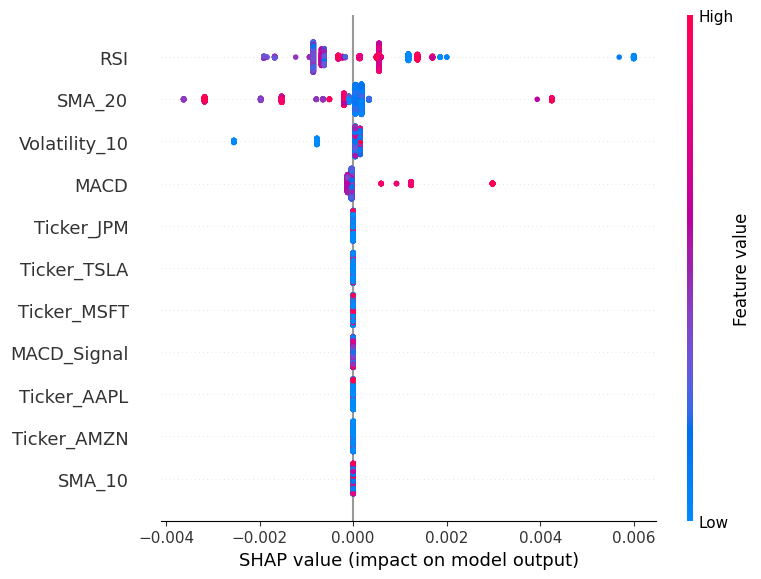

In [26]:
## SHAP Analysis for interpretability
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)